<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# RAPIDS Evaluation

[RAPIDS](https://rapids.ai/about.html) is an open source software libraries and APIs to provide ability to execute end-to-end data science and analytics pipelines entirely on **GPU**. It is designed to have a familiar look and feel to data scientist working in Python. Our repository implements recommender's common evaluation metrics by utilizing RAPIDS [cuDF](https://docs.rapids.ai/api/cudf/stable/) to speed up the calculation so that users can use that if their computing environment meets the RAPIDS requirements. 

This notebook benchmarks speed of evaluation metric calculations based on Pandas DataFrame vs. cuDF DataFrame.

#### Requirements (v0.8)
* GPU: NVIDIA Pascal™ or better with compute capability 6.0+
  - Azure Data Science Virtual Machine (DSVM) [NC6v2](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/sizes-gpu#ncv2-series) or [NC6v3](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/sizes-gpu#ncv3-series) are good computing resources to start with 
* Supported OS: Ubuntu 16.04/18.04 or CentOS 7 with gcc 5.4 & 7.3
* To use docker - Docker CE v18+ and NVIDIA-docker v2+
* CUDA: 9.2 with driver v396.37+ or 10.0 with driver v410.48+
  - CUDA 10.1 is not supported in v0.8, support will be added soon
  
#### Installation
For now, recommender repository SETUP doesn't officially support RAPIDS environment because of the (relatively) hard requirements described above. To setup,
run following command on the machine that meets the requirement.
```
# TODO
```

## 0 Global settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
import math
import time

import cudf as cu
import numpy as np
import pandas as pd

from reco_utils.common.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
)
from reco_utils.common.plot import bar_chart
from reco_utils.dataset import movielens
from reco_utils.dataset.pandas_df_utils import user_item_pairs
from reco_utils.dataset.python_splitters import python_random_split
import reco_utils.evaluation.python_evaluation as pd_evaluator
import reco_utils.evaluation.rapids_evaluation as cu_evaluator

print("Pandas version: {}".format(pd.__version__))
print("CuDF version: {}".format(cu.__version__))

Pandas version: 0.24.2
CuDF version: 0.8.0+0.g8fa7bd3.dirty


In [3]:
MOVIELENS_DATA_SIZE = '100k'

## 1 Prepare data

### 1.1 Prepare dummy data

For illustration purpose, a dummy data set is created for demonstrating how different evaluation metrics work. 

The data has the schema that can be frequently found in a recommendation problem, that is, each row in the dataset is a (user, item, rating) tuple, where "rating" can be an ordinal rating score (e.g., discrete integers of 1, 2, 3, etc.) or an numerical float number that quantitatively indicates the preference of the user towards that item. 

For simplicity reason, the column of rating in the dummy dataset we use in the example represent some ordinal ratings.

In [4]:
pd_data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=[USER_COL, ITEM_COL, RATING_COL],
)
pd_data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 18.5kKB/s]


,userID,itemID,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [5]:
items = pd_data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
users = pd_data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

pd_pred = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
)
pd_pred[PREDICT_COL] = 3.0

pd_pred.head()

,userID,itemID,prediction
0,135,590,3.0
1,348,958,3.0
2,710,1668,3.0
3,254,833,3.0
4,520,522,3.0


In [6]:
print(
    "Num data = {}\n"
    "Num items = {}\n"
    "Num users = {}\n"
    "Num predictions = {}".format(len(pd_data), len(items), len(users), len(pd_pred))
)

Num data = 100000
Num items = 1682
Num users = 943
Num predictions = 1586126


In [7]:
cu_data = cu.from_pandas(pd_data)
cu_pred = cu.from_pandas(pd_pred)

## 2 Evaluation metrics

In [8]:
cols = {
    "col_user": USER_COL,
    "col_item": ITEM_COL,
    "col_rating": RATING_COL,
    "col_prediction": PREDICT_COL,
}

In [9]:
DEFAULT_USER_COL = USER_COL
DEFAULT_ITEM_COL = ITEM_COL
DEFAULT_RATING_COL = RATING_COL
DEFAULT_PREDICTION_COL = PREDICT_COL

TOL = 0.0001

### 2.1 Rating metrics

#### 2.1.1 Root Mean Square Error (RMSE)

In [136]:
start = time.time()
pd_rmse = pd_evaluator.rmse(pd_data, pd_pred, **cols)
pd_rmse_time = time.time() - start
print("RMSE with Pandas = {}, took {} seconds".format(pd_rmse, pd_rmse_time))

RMSE with Pandas = 1.244138255982831, took 1.0524075031280518 seconds


In [137]:
start = time.time()
cu_rmse = cu_evaluator.rmse(cu_data, cu_pred, **cols)
cu_rmse_time = time.time() - start
print("RMSE with Rapids.cuDF = {}, took {} seconds".format(cu_rmse, cu_rmse_time))

RMSE with Rapids.cuDF = 1.244138255982831, took 0.008550643920898438 seconds


In [138]:
assert math.isclose(pd_rmse, cu_rmse, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.2 Mean Absolute Error (MAE)

In [139]:
start = time.time()
pd_mae = pd_evaluator.mae(pd_data, pd_pred, **cols)
pd_mae_time = time.time() - start
print("MAE with Pandas = {}, took {} seconds".format(pd_mae, pd_mae_time))

MAE with Pandas = 1.00166, took 2.314361572265625 seconds


In [140]:
start = time.time()
cu_mae = cu_evaluator.mae(cu_data, cu_pred, **cols)
cu_mae_time = time.time() - start
print("MAE with Rapids.cuDF = {}, took {} seconds".format(cu_mae, cu_mae_time))

MAE with Rapids.cuDF = 1.00166, took 0.009862899780273438 seconds


In [141]:
assert math.isclose(pd_mae, cu_mae, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.3 Summary

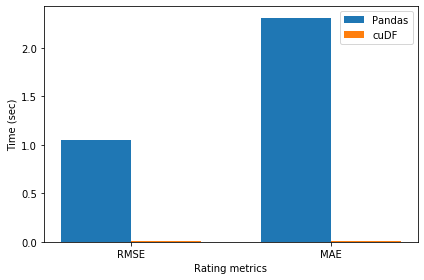

In [142]:
values = [
    [pd_rmse_time, pd_mae_time],
    [cu_rmse_time, cu_mae_time]
]
labels = ['Pandas', 'cuDF']

bar_chart(values, labels, errors=None, x_name="Rating metrics", y_name="Time (sec)", tick_labels=['RMSE', 'MAE'])

### 2.2 Ranking metrics

In [10]:
DEFAULT_K = 10
DEFAULT_THRESHOLD = 10

#### 2.2.1 Precision

In [143]:
start = time.time()
pd_prec = pd_evaluator.precision_at_k(pd_data, pd_pred, k=DEFAULT_K, **cols)
pd_prec_time = time.time() - start
print("Precision at K with Pandas = {}, took {} seconds".format(pd_prec, pd_prec_time))

Precision at K with Pandas = 0.06139978791092259, took 2.255455732345581 seconds


In [144]:
start = time.time()
cu_prec = cu_evaluator.precision_at_k(cu_data, cu_pred, k=DEFAULT_K, **cols)
cu_prec_time = time.time() - start
print("Precision at K with Rapids.cuDF = {}, took {} seconds".format(cu_prec, cu_prec_time))

Precision at K with Rapids.cuDF = 0.061399785483755714, took 0.2834043502807617 seconds


In [145]:
assert math.isclose(pd_prec, cu_prec, rel_tol=1e-06, abs_tol=1e-06)

#### 2.2.2 Recall

In [146]:
start = time.time()
pd_rec = pd_evaluator.recall_at_k(pd_data, pd_pred, k=DEFAULT_K, **cols)
pd_rec_time = time.time() - start
print("Recall at K with Pandas = {}, took {} seconds".format(pd_rec, pd_rec_time))

Recall at K with Pandas = 0.005594971917398692, took 2.2701282501220703 seconds


In [147]:
start = time.time()
cu_rec = cu_evaluator.recall_at_k(cu_data, cu_pred, k=DEFAULT_K, **cols)
cu_rec_time = time.time() - start
print("Recall at K with Rapids.cuDF = {}, took {} seconds".format(cu_rec, cu_rec_time))

Recall at K with Rapids.cuDF = 0.005594971917398693, took 0.18432164192199707 seconds


In [148]:
assert math.isclose(pd_rec, cu_rec, rel_tol=1e-06, abs_tol=1e-06)

#### 2.2.3 Normalized Discounted Cumulative Gain (NDCG)

In [121]:
start = time.time()
pd_ndcg = pd_evaluator.ndcg_at_k(pd_data, pd_pred, k=DEFAULT_K, **cols)
pd_ndcg_time = time.time() - start
print("NDCG at K with Pandas = {}, took {} seconds".format(pd_ndcg, pd_ndcg_time))

NDCG at K with Pandas = 0.06265999935275099, took 2.325124979019165 seconds


In [133]:
start = time.time()
cu_ndcg = cu_evaluator.ndcg_at_k(cu_data, cu_pred, k=DEFAULT_K, **cols)
cu_ndcg_time = time.time() - start
print("NDCG at K with Rapids.cuDF = {}, took {} seconds".format(cu_ndcg, cu_ndcg_time))

NDCG at K with Rapids.cuDF = 0.06265999935275099, took 0.5983891487121582 seconds


In [135]:
assert math.isclose(pd_ndcg, cu_ndcg, rel_tol=1e-06, abs_tol=1e-06)

#### 2.2.4 Mean Average Precision (MAP)

In [ ]:
# TODO...

#### 2.2.5 Summary

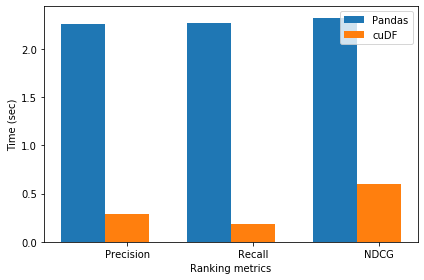

In [149]:
values = [
    [pd_prec_time, pd_rec_time, pd_ndcg_time],
    [cu_prec_time, cu_rec_time, cu_ndcg_time]
]
labels = ['Pandas', 'cuDF']

bar_chart(values, labels, errors=None, x_name="Ranking metrics", y_name="Time (sec)", tick_labels=['Precision', 'Recall', 'NDCG'])